# 1) Import Libraries

In [2]:
import pandas as pd
import os
import requests
import io
import numpy as np
import datetime
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 2) Import Data
## 2.1) Set Folder Path

In [3]:
PATH = '..\data' # should be the only path used in the future. Jupyter notebook has to be launched from
print(os.getcwd())

C:\Users\maxim\OneDrive\Desktop\Unibo\Machine Learning Systems for Data Science_90477\Module II\Final Project\pr7-main\scripts


## 2.2) Import Air Quality data from Local Path

In [4]:
# Select one of the paths here
air_PATH = os.path.join(PATH, 'new-york-air-quality.csv')
air = pd.read_csv(air_PATH, parse_dates = ['date'])
print(air.columns) # renaming neccesary for the last 4 columns
air.rename(columns={' pm25': 'pm25', ' o3': 'o3', ' no2': 'no2', ' co': 'co'}, inplace = True)

# Overview
air.info() # We can see that the columns in air need to be converted to 'int64'
air.describe(include = 'all', datetime_is_numeric = True) # 'datetime_is_numeric = True' is used to silence a known Python warning
print(air.head())

Index(['date', ' pm25', ' o3', ' no2', ' co'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3207 entries, 0 to 3206
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3207 non-null   datetime64[ns]
 1   pm25    3207 non-null   object        
 2   o3      3207 non-null   object        
 3   no2     3207 non-null   object        
 4   co      3207 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 125.4+ KB
        date pm25   o3  no2  co
0 2022-11-01   40   28   20   3
1 2022-11-02   45   23   25   3
2 2022-11-03   53   17   26   4
3 2022-11-04   47   24   10   1
4 2022-11-05   31   21    6   1


## 2.3) Import NYC Health data from Github repository

In [5]:
url_health = 'https://raw.githubusercontent.com/nychealth/coronavirus-data/master/trends/data-by-day.csv'
download_health = requests.get(url_health).content
health = pd.read_csv(io.StringIO(download_health.decode('utf-8')), sep = ',', parse_dates= ['date_of_interest'])

# Overview
health.info()
health.describe(include = 'all', datetime_is_numeric = True) # 'datetime_is_numeric = True' is used to silence a known Python warning
print(health.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 67 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_of_interest                 1031 non-null   datetime64[ns]
 1   CASE_COUNT                       1031 non-null   int64         
 2   PROBABLE_CASE_COUNT              1031 non-null   int64         
 3   HOSPITALIZED_COUNT               1031 non-null   int64         
 4   DEATH_COUNT                      1031 non-null   int64         
 5   PROBABLE_DEATH_COUNT             1031 non-null   int64         
 6   CASE_COUNT_7DAY_AVG              1031 non-null   int64         
 7   ALL_CASE_COUNT_7DAY_AVG          1031 non-null   int64         
 8   HOSP_COUNT_7DAY_AVG              1031 non-null   int64         
 9   DEATH_COUNT_7DAY_AVG             1031 non-null   int64         
 10  ALL_DEATH_COUNT_7DAY_AVG         1031 non-null   int64      

# 3) Process and merge data
## 3.1) Process data

In [6]:
# 3.1.1) Convert the date column and sort the data by dates; Print the date range

def convert_sort_date_rows(data, date_column_name):
    
    # Use date_column_name to create a column index number
    date_column_index = data.columns.get_loc(date_column_name)
    
    # Convert datetime column to date-format without loosing the Dtype 'datetime64[ns]'
    data.iloc[:, date_column_index] = pd.to_datetime(data.iloc[:, date_column_index])
    
    # Sort by date_column_name and print the date range
    data = data.sort_values(by = date_column_name)
    date_range_min = min(data.iloc[:, date_column_index].dt.strftime('%Y-%m-%d'))
    date_range_max = max(data.iloc[:, date_column_index].dt.strftime('%Y-%m-%d'))
    print(f'Date range: {date_range_min}, {date_range_max}')
    
    return(data)

In [7]:
# 3.1.2) Apply the convert_sort_date_rows() function to air data
air = convert_sort_date_rows(data = air, date_column_name = 'date')

Date range: 2014-01-01, 2022-11-20


In [8]:
# 3.1.3) Apply the convert_sort_date_rows() function to health data
health = convert_sort_date_rows(data = health, date_column_name = 'date_of_interest')

# We can see that no date range includes the other. We therefore need an outer merge in 3.2)

Date range: 2020-02-29, 2022-12-25


In [9]:
# 3.1.4) Find missing date rows in both air and health and add the missing rows

def add_missing_date_rows(data, date_column_name):
    
    # Before dropping the date_column_name (see below): Use it to create a column index number and the date range min/max
    date_column_index = data.columns.get_loc(date_column_name)
    date_range_min = min(data.iloc[:, date_column_index].dt.strftime('%Y-%m-%d'))
    date_range_max = max(data.iloc[:, date_column_index].dt.strftime('%Y-%m-%d'))
    data = data.set_index(date_column_name, drop = True) # Set date as index; the original date_column_name is dropped here
    
    # Find missing date rows
    data.index = pd.to_datetime(data.index) # format to date time object
    date_missing_before = pd.date_range(start = str(date_range_min), end = str(date_range_max)).difference(data.index)
    print(str(date_missing_before.size) + " date rows are missing (before fix)")
    print(date_missing_before) 
    
    # Add the missing date rows
    date_range = pd.date_range(str(date_range_min), str(date_range_max)) # creates perfect date range
    data.index = pd.DatetimeIndex(data.index)
    data = data.reindex(date_range)
    date_missing_after = pd.date_range(start = str(date_range_min), end = str(date_range_max)).difference(data.index)
    print(str(date_missing_after.size) + " date rows are missing (after fix)")
    print(date_missing_after)
    
    data.reset_index(inplace = True, drop = False) # needed to undo the index setting above; inplace = True means the 
    # original air dataframe is targeted; drop = False retrieves the original date column.
    data.rename(columns={'index': date_column_name}, inplace = True) # returning to original column name, so this cell can be re-run easier
    
    return(data)


In [10]:
# 3.1.5) Apply the add_missing_date_rows() function to air data
air = add_missing_date_rows(data = air, date_column_name = 'date')

39 date rows are missing (before fix)
DatetimeIndex(['2014-12-29', '2014-12-30', '2014-12-31', '2016-01-01',
               '2017-01-28', '2017-09-06', '2017-09-07', '2017-09-08',
               '2018-12-31', '2019-10-07', '2019-10-08', '2019-10-09',
               '2019-10-10', '2019-10-11', '2019-10-12', '2019-10-13',
               '2019-10-14', '2019-10-15', '2019-10-16', '2019-10-17',
               '2019-10-18', '2019-10-19', '2019-10-20', '2019-10-21',
               '2019-10-22', '2019-10-23', '2019-10-24', '2019-10-25',
               '2019-10-26', '2019-10-27', '2019-10-28', '2019-10-29',
               '2019-10-30', '2019-10-31', '2019-11-01', '2019-11-02',
               '2019-12-30', '2019-12-31', '2020-03-30'],
              dtype='datetime64[ns]', freq=None)
0 date rows are missing (after fix)
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [11]:
# 3.1.6) Apply the add_missing_date_rows() function to health data
health = add_missing_date_rows(data = health, date_column_name = 'date_of_interest')

0 date rows are missing (before fix)
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
0 date rows are missing (after fix)
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


## 3.2) Merge data from air and health into the final dataframe; process the data

In [15]:
# 3.2.1) Outer merge air and health by their date columns; change all variables of interest to Dtype 'int64'
df_merged = pd.merge(air, health, how = 'outer', left_on = 'date', right_on = 'date_of_interest')
print(df_merged.iloc[0, [0, 5]]) # to check that the merged dataframe starts from the first possible date of both air and health
print(df_merged.iloc[-1, [0, 5]]) # to check that the merged dataframe ends on the last possible date of both air and health
air_date_range_min = min(air.loc[:, 'date'].dt.strftime('%Y-%m-%d'))
air_date_range_max = max(air.loc[:, 'date'].dt.strftime('%Y-%m-%d'))
health_date_range_min = min(health.loc[:, 'date_of_interest'].dt.strftime('%Y-%m-%d'))
health_date_range_max = max(health.loc[:, 'date_of_interest'].dt.strftime('%Y-%m-%d'))
print(f'Date range for air: {air_date_range_min}, {air_date_range_max}')
print(f'Date range for health: {health_date_range_min}, {health_date_range_max}')
# The date range matches.

# 3.2.2) Create date_merged column which combines the entries from both date columns
df_merged['date_merged'] = df_merged['date']
df_merged['date_merged'] = df_merged.date_merged.combine_first(df_merged.date)

# 3.2.3 Create final dataframe
set_start_date = '2020-03-03'
set_end_date = '2020-06-26'
index_start_date = df_merged.loc[df_merged.date_merged == set_start_date].index[0]
index_end_date = df_merged.loc[df_merged.date_merged == set_end_date].index[0]
df_final = df_merged.copy()
df_final = df_final.loc[index_start_date:index_end_date, ['date_merged', 'pm25', 'no2', 'DEATH_COUNT']]
df_final.head()

date                2014-01-01 00:00:00
date_of_interest                    NaT
Name: 0, dtype: object
date                                NaT
date_of_interest    2022-12-25 00:00:00
Name: 3280, dtype: object
Date range for air: 2014-01-01, 2022-11-20
Date range for health: 2020-02-29, 2022-12-25


,date_merged,pm25,no2,DEATH_COUNT
2253,2020-03-03,37,10,0.0
2254,2020-03-04,20,12,0.0
2255,2020-03-05,20,19,0.0
2256,2020-03-06,23,9,0.0
2257,2020-03-07,24,12,0.0


## 3.3) Process final dataframe

In [16]:
# 3.3.1) Rename columns
df_final.rename(columns={'date_merged': 'date', 'DEATH_COUNT': 'death'}, inplace = True)
df_final

# 3.3.2) Change datatypes; for pm25 and no2 we replace empty values by NaN and use a linear interpolation to replace NaN
df_final = df_final.replace(r'^\s*$', np.nan, regex=True) 
df_final[['pm25', 'no2']] = df_final[['pm25', 'no2']].astype(float).interpolate(method = 'linear').round(0).astype(np.int64)
df_final.loc[:, 'death'] = df_final.loc[:, 'death'].astype(np.int64)

# 3.3.3) Create additional log, difference and percentage variables
df_final[['ln_pm25', 'ln_no2', 'ln_death']] = np.log(df_final[['pm25', 'no2', 'death']]) # warning: log(0) = -Inf
df_final[['d_pm25', 'd_no2', 'd_death']] = df_final[['pm25', 'no2', 'death']].diff(periods = 1, axis = 0)
df_final.replace([np.inf, -np.inf], np.nan, inplace = True) # replace Inf and -Inf by NaN

C:\Users\maxim\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning:

divide by zero encountered in log



## 3.4) View the whole final dataframe

In [17]:
with pd.option_context('display.max_rows', None):
   print(df_final)

df_final.head()
df_final.info()

           date  pm25  no2  death   ln_pm25    ln_no2  ln_death  d_pm25  \
2253 2020-03-03    37   10      0  3.610918  2.302585       NaN     NaN   
2254 2020-03-04    20   12      0  2.995732  2.484907       NaN   -17.0   
2255 2020-03-05    20   19      0  2.995732  2.944439       NaN     0.0   
2256 2020-03-06    23    9      0  3.135494  2.197225       NaN     3.0   
2257 2020-03-07    24   12      0  3.178054  2.484907       NaN     1.0   
2258 2020-03-08    27   24      0  3.295837  3.178054       NaN     3.0   
2259 2020-03-09    47   21      0  3.850148  3.044522       NaN    20.0   
2260 2020-03-10    43   15      0  3.761200  2.708050       NaN    -4.0   
2261 2020-03-11    26   19      1  3.258097  2.944439  0.000000   -17.0   
2262 2020-03-12    39   13      0  3.663562  2.564949       NaN    13.0   
2263 2020-03-13    28    7      0  3.332205  1.945910       NaN   -11.0   
2264 2020-03-14    28    7      2  3.332205  1.945910  0.693147     0.0   
2265 2020-03-15    22   1

# 4) Descriptive plots
## 4.1) Scatterplots


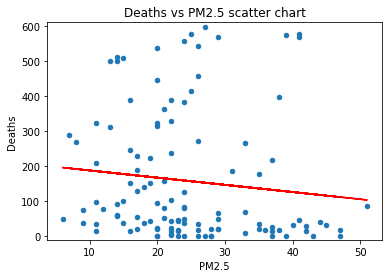

In [18]:
# 4.1.1) Deaths vs PM2.5
df_final.plot.scatter(x = 'pm25',
                     y = 'death',
                     ylim = (-10, 610)
                     )
# Add title and axis names
plt.title('Deaths vs PM2.5 scatter chart')
plt.xlabel('PM2.5')
plt.ylabel('Deaths')

# Create linear regression
X = df_final.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array ->PM2.5
Y = df_final.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column-> Death
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='red')
plt.show()

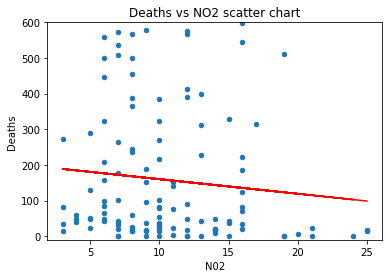

In [19]:
# 4.1.2) Deaths vs NO2
df_final.plot.scatter(x = 'no2',
                     y = 'death',
                     ylim = (-10, 600))
# Add title and axis names
plt.title('Deaths vs NO2 scatter chart')
plt.xlabel('N02')
plt.ylabel('Deaths')

# Create linear regression
X = df_final.iloc[:, 2].values.reshape(-1, 1)  # values converts it into a numpy array -> NO2
Y = df_final.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column-> Death
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='red')
plt.show()

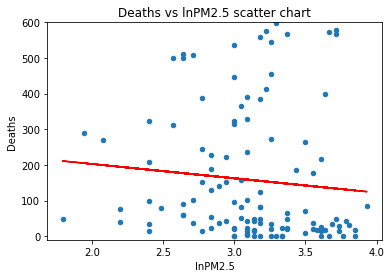

In [20]:
# 4.1.3) Deaths vs lnPM2.5
df_final.plot.scatter(x = 'ln_pm25',
                     y = 'death',
                     ylim = (-10, 600))
# Add title and axis names
plt.title('Deaths vs lnPM2.5 scatter chart')
plt.xlabel('lnPM2.5')
plt.ylabel('Deaths')

# Create linear regression
X = df_final.iloc[:, 4].values.reshape(-1, 1)  # values converts it into a numpy array ->lnPM2.5
Y = df_final.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column-> Death
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='red')
plt.show()

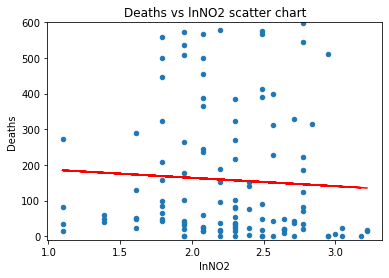

In [21]:
# 4.1.4) Deaths vs lnNO2
df_final.plot.scatter(x = 'ln_no2',
                     y = 'death',
                     ylim = (-10, 600))
# Add title and axis names
plt.title('Deaths vs lnNO2 scatter chart')
plt.xlabel('lnNO2')
plt.ylabel('Deaths')

#Create linear regression
X = df_final.iloc[:, 5].values.reshape(-1, 1)  # values converts it into a numpy array -> lnNO2
Y = df_final.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column-> Death
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='red')
plt.show()

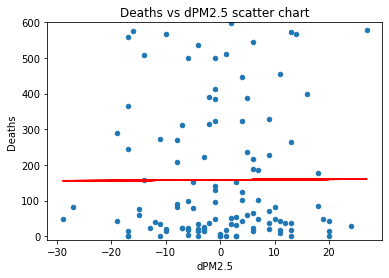

In [22]:
# 4.1.5) Deaths vs dPM2.5
df_final.plot.scatter(x = 'd_pm25',
                     y = 'death',
                     ylim = (-10, 600))
# Add title and axis names
plt.title('Deaths vs dPM2.5 scatter chart')
plt.xlabel('dPM2.5')
plt.ylabel('Deaths')

#Create linear regression
##small comment: DataFrame has NaN values so we have at least 2 solution: 
                    # 1. remove rows with NaN values
                    # 2. replace the NaN values with the mean -> I chose the second one because it seems more reasonable to me
                        ##if you have other suggestions tell me
            
X_new=df_final.iloc[:, 7].fillna(df_final.iloc[:, 7].mean()) #replace the NaN values with the mean 
X = X_new.values.reshape(-1, 1)  # values converts it into a numpy array -> dPM2.5
Y = df_final.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column-> Death
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='red')
plt.show()

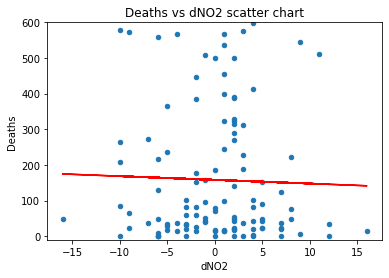

In [23]:
# 4.1.6) Deaths vs dNO2
df_final.plot.scatter(x = 'd_no2',
                     y = 'death',
                     ylim = (-10, 600)
                     )
# Add title and axis names
plt.title('Deaths vs dNO2 scatter chart')
plt.xlabel('dNO2')
plt.ylabel('Deaths')

#Create linear regression
X_new=df_final.iloc[:, 8].fillna(df_final.iloc[:, 8].mean()) #replace the NaN values with the mean
X = X_new.values.reshape(-1, 1)  # values converts it into a numpy array -> dNO2
Y = df_final.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column-> Death
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='red')
plt.show()

## 4.2) Plotting by date

In [24]:
# 4.2.1) Timeline of confirmed deaths
fig = px.line(df_final, x = 'date', y = 'death')

fig.update_layout(title = 'Timeline of confirmed deaths', 
                  xaxis_title = 'Date', yaxis_title = 'Confirmed deaths',  
                  legend = dict(yanchor = "top", y = 0.99, xanchor = "right", x = 0.99))

fig.update_traces(line_color='darkcyan', line_width = 3)

fig.add_trace(go.Scatter(x = df_final['date'], y = [200]*len(df_final), 
                          mode = 'lines', name = '200 count line', 
                          line = dict(dash = 'dash', color = 'gray')))

fig.add_trace(go.Scatter(x = df_final['date'], y = [400]*len(df_final), 
                          mode = 'lines', name = '400 count line', 
                          line = dict(dash = 'dash', color = 'maroon')))

fig.add_trace(go.Scatter(x=df_final['date'], y = [600]*len(df_final), 
                          mode = 'lines', name = '600 count line', 
                          line = dict(dash = 'dash', color = 'black')))

In [25]:
# 4.2.2) Timeline of PM2.5 and NO2 concentration levels
fig = px.line(df_final, x = 'date', y = 'pm25')

fig.add_trace(go.Scatter(x = df_final.date, y = df_final.pm25, 
                        mode = 'lines', name = 'PM2.5', line_color = 'darkorange', line_width = 2))

fig.add_trace(go.Scatter(x = df_final.date, y = df_final.no2, 
                        mode = 'lines', name = 'NO2', line_color = 'mediumblue', line_width = 2))

fig.update_layout(title = 'Timeline of PM2.5 and NO2 concentration levels', 
                  xaxis_title = 'Date', yaxis_title = '$\\mu g / m^{3}$', 
                  legend = dict(yanchor = "top", y = 0.99, xanchor = "right", x = 0.99))

In [26]:
# 4.2.3) Timeline of confirmed deaths and PM2.5 concentration levels
fig = px.bar(df_final.sort_values('death', ascending = False), 
       x = "date", y = "death", color = 'pm25', 
       title = 'Timeline of confirmed deaths and PM2.5 concentration levels',
       color_discrete_sequence = px.colors.qualitative.Vivid)

fig.update_traces(textposition = 'outside')
fig.update_layout(uniformtext_minsize = 8, uniformtext_mode = 'hide', xaxis_title = 'Date', yaxis_title = 'Confirmed deaths')
fig.show()

In [27]:
# 4.2.4) Timeline of confirmed deaths and NO2 concentration levels
fig = px.bar(df_final.sort_values('death', ascending = False), 
       x = "date", y = "death", color = 'no2', 
       title = 'Deaths and NO2 concentration levels over time',
       color_discrete_sequence = px.colors.qualitative.Vivid)

fig.update_traces(textposition = 'outside')
fig.update_layout(uniformtext_minsize = 8, uniformtext_mode = 'hide', xaxis_title = 'Date', yaxis_title = 'Confirmed deaths')
fig.show()

# 5) Prediction with Artificial Neural Networks (ANNs)
## 5.1) Something with Apache Spark -> Oryx 2.8.0

In [2]:
pip install spylon-kernel

  Created wheel for spylon-kernel: filename=spylon_kernel-0.4.1-py2.py3-none-any.whl size=18370 sha256=f15db843211126a04316e286be606106c4454f93553ba1459fe2a0df8410eb83
  Stored in directory: c:\users\maxim\appdata\local\pip\cache\wheels\f8\f1\04\7b6c8644c458aeb767c82f459c06b8074c63339e8c5654e551
  Created wheel for spylon: filename=spylon-0.3.0-py3-none-any.whl size=136189 sha256=f79cc85f9b13fe88210a06c9ebd881f11571cc47d4d6d7db12263589c81b547f
  Stored in directory: c:\users\maxim\appdata\local\pip\cache\wheels\2e\df\61\860b966d814585b16ac84f72060ca1578b17bdb7f8684f26d6
Successfully built spylon-kernel spylon
Note: you may need to restart the kernel to use updated packages.


In [4]:
# run this ins anaconda powershell prompt
python -m spylon_kernel install

SyntaxError: invalid syntax (4040037691.py, line 1)

In [5]:
sudo apt install default-jdk scala git -y

SyntaxError: invalid syntax (886566313.py, line 1)